**РЕЗЮМЕ И ВЫВОД** по работе (чтобы не спускаться в самый низ):

    - В данной работе была предпринята попытка предсказать возможность дождя на следующий день на основе данных гидрометцентра за 10 лет в Австралии. Была поставлена задача классификации.
    
    https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
    
    - В качестве признаков было представлено несколько полей, обзор, анализ, визуализация и обработка которых представлена в разделе "Обзор данных и признаков".
    
    - Отдельный и один из самых важных (и скорее всего спорных) разделов - "Обработка пропущенных значений" также представлен в работе. Была проведена замена пропущенных значений различными способами, исходя из результатов распределений и типа данных (дискретных, непрерывных и тд величин).
    
**1.**
    
    - В качестве бейзлайна на основе оригинальных данных с обработанными пропущенными значениями была представлена модель Логистической Регрессии, результаты которой на тестовой выборке:
    Accuracy: 0.82084
    Precision: 0.6562
    Recall: 0.3808
    ROC_AUC: 0.8184
    
    - После этого были созданы новые колонки в разделе "Создание и преобразование новых признаков", соответственно, результат улучшился на предыдущей модели и достиг показателей:
    Accuracy: 0.8433
    Precision: 0.7215
    Recall: 0.4763
    ROC_AUC: 0.8582
 
    - Для улучшения показателей была проведена балансировка классов целевой переменной методом undersampling, после чего результат улучшился до показателей:
    Accuracy: 0.7717
    Precision: 0.7855
    Recall: 0.7502
    ROC_AUC: 0.8577
    Можно заметить, что результат по Recall сильно улучшился как раз благодаря балансировке классов.
    
    - В качестве дальнейшей попытки улучшения модели Логистической Регрессии также было опробовано масштабирование данных методов MinMax. Результат изменился до показателей:
    Accuracy: 0.7871
    Precision: 0.7980
    Recall: 0.7726
    ROC_AUC: 0.8703
    
**2.**

    - В качестве альтернативы была опробована модель RandomForest, на несбалансированных классах целевой переменной результат получился:
    Accuracy: 0.8539
    Precision: 0.7756
    Recall: 0.4912
    ROC_AUC: 0.8837
    
    - На сбалансированных классах и на подобранных гиперпараметрах с помощью CVGridSearch RandomForest показал:
    Accuracy: 0.7789
    Precision: 0.7854
    Recall: 0.7661
    ROC_AUC: 0.8630
    Поиск проходил по гиперпараметрам n_estimators, max_depth, max_features, criterion.
    
**3.**

    - Использование GradientBoosting из библиотеки sklearn:
    Accuracy: 0.7853
    Precision: 0.7887
    Recall: 0.7779
    ROC_AUC: 0.8705
    Так как результат улучшился, то была предпринята попытка продолжить тему с градиентным бустингом:
    
    - XGBoost без подбора гиперпараметров:
    Accuracy: 0.8028
    Precision: 0.8018
    Recall: 0.7984
    ROC_AUC: 0.8862
    
    -XGBoost с подбором гиперпараметров при помощи CVGridSearch:
    Accuracy: 0.8058
    Precision: 0.8094
    Recall: 0.7972
    ROC_AUC: 0.8897
    Поиск проходил по гиперпараметрам: learning_rate, gamma, max_depth, n_estimators.
    
    
**Итого: был проведен анализ данных гидрометцентра за 10 лет, а также прогнозирование дождня на следующий день. Лучший результат показала модель XGBoostClassifier. Результат работы:**
    
    Accuracy: 0.8058
    Precision: 0.8094
    Recall: 0.7972
    ROC_AUC: 0.8897

    
    

    

## Загрузка библиотек:

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.ticker as tick
import random

from sklearn.impute import SimpleImputer
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

pd.set_option('max_columns', None)
from tqdm import tqdm, tqdm_notebook
#sns.set(rc={'figure.figsize':(17,10)})

In [3]:
data = pd.read_csv('weatherAUS.csv')

In [4]:
data.shape

(145460, 23)

**Для задачи будем использовать датасет - набор данных, который содержит около 10 лет ежедневных наблюдений за погодой из многих мест по всей Австралии.**

RainTomorrow — целевая переменная для прогнозирования.  Это означает -- шел ли дождь на следующий день, да или нет?  В этом столбце указано «Да», если в этот день выпало 1 мм дождя и более. **Нужно предсказать именно этот признак.**

## **Обзор данных и признаков:**

In [23]:
data.sample(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
141939,2016-06-26,Darwin,24.0,32.7,0.0,5.6,7.9,E,31.0,SSE,NNW,13.0,17.0,83.0,52.0,1013.9,1010.0,8.0,4.0,25.8,31.4,No,No
80931,2017-04-20,Watsonia,13.4,25.8,0.0,7.4,5.1,ENE,28.0,NE,ENE,11.0,13.0,48.0,36.0,1026.4,1022.3,3.0,7.0,21.3,25.5,No,Yes
61920,2011-01-09,Sale,18.5,24.8,0.0,7.6,1.9,SE,46.0,SSW,SSE,13.0,20.0,74.0,58.0,1019.6,1018.6,7.0,7.0,19.3,24.0,No,Yes


**Всего 145460 записей.**



**Назначение колонок:**

**- Date: дата в разрезе по дням.**

**- Location: расположение метеостанции.**

**- MinTemp и MaxTemp: минимальная и максимальная температура в Цельсиях.**

**- Rainfall: сумма осадков выпавших за сутки в мм ртутного столба.**

**- Evaporation: испарение кастрюли класса А (мм) за 24 часа до 9 утра в мм.**

**- Sunshine: количество солнечных часов.**

**- WindGustDir, WindGustSpeed: направление и скорость максимально сильного ветра за день.**

**- WindDir9am, WindDir3pm: направление ветра в 9:00 и 15:00, всего несколько направлений.**

**- WindSpeed9am, WindSpeed3pm: средняя скорость ветра (км/ч) за 10 минут до 9:00 и за 10 минут до 15:00, км/ч.**

**- Humidity9am, Humidity3pm: влажность в 9:00 и в 15:00 в %.**

**- Pressure9am, Pressure3pm: давление в 9:00 и в 15:00 в ГПа, гектопаскалях.**

**- Cloud9am, Cloud3pm: фрагмент неба, закрытый облаком в 9 утра и в 15:00.  Это измеряется в «октах».**

**- Temp9am, Temp3pm: температура в Цельсиях в 9 утра и в 15:00.**

**- RainToday, RainTomorrow: метка-дождь сегодня (1,0) и метка-дождь завтра (1,0).**



## Визуализация признаков и их зависимостей:

**Процент выбросов в каждой строке:**

In [22]:
for i in ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
          'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 
          'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 
          'Cloud9am', 'Cloud3pm', 'Temp3pm']:
    print(f'Процент выбросов для колонки {i}',len(data[(data[i]>(data[i].quantile(0.75) + 1.5*(data[i].quantile(0.75)-data[i].quantile(0.25))))|(data[i]<(data[i].quantile(0.25) - 1.5*(data[i].quantile(0.75)-data[i].quantile(0.25))))])*100/len(data))
    

Процент выбросов для колонки MinTemp 0.037123607864705074
Процент выбросов для колонки MaxTemp 0.3361748934414959
Процент выбросов для колонки Rainfall 17.584215591915303
Процент выбросов для колонки Evaporation 1.3715110683349374
Процент выбросов для колонки Sunshine 0.0
Процент выбросов для колонки WindGustSpeed 2.125670287364224
Процент выбросов для колонки WindSpeed9am 1.249140657225354
Процент выбросов для колонки WindSpeed3pm 1.734497456345387
Процент выбросов для колонки Humidity9am 0.9796507630963839
Процент выбросов для колонки Pressure9am 0.8187817956826619
Процент выбросов для колонки Cloud9am 0.0
Процент выбросов для колонки Cloud3pm 0.0
Процент выбросов для колонки Temp3pm 0.5252303038636051


**Процент пропусков в каждой колонке:**

In [16]:
for i in data.columns:
    print(f'{i}:', data[i].isna().sum()*100/len(data))

Date: 0.0
Location: 0.0
MinTemp: 1.0208992162793895
MaxTemp: 0.8669049910628351
Rainfall: 2.241853430496356
Evaporation: 43.1665062560154
Sunshine: 48.00976213391998
WindGustDir: 7.09885879279527
WindGustSpeed: 7.055547916953114
WindDir9am: 7.263852605527292
WindDir3pm: 2.906641000962464
WindSpeed9am: 1.214766946239516
WindSpeed3pm: 2.105046060772721
Humidity9am: 1.8245565791282827
Humidity3pm: 3.09844630826344
Pressure9am: 10.356799120033
Pressure3pm: 10.331362573903478
Cloud9am: 38.42155919153032
Cloud3pm: 40.80709473394748
Temp9am: 1.214766946239516
Temp3pm: 2.4810944589577892
RainToday: 2.241853430496356
RainTomorrow: 2.245978275814657


<AxesSubplot:>

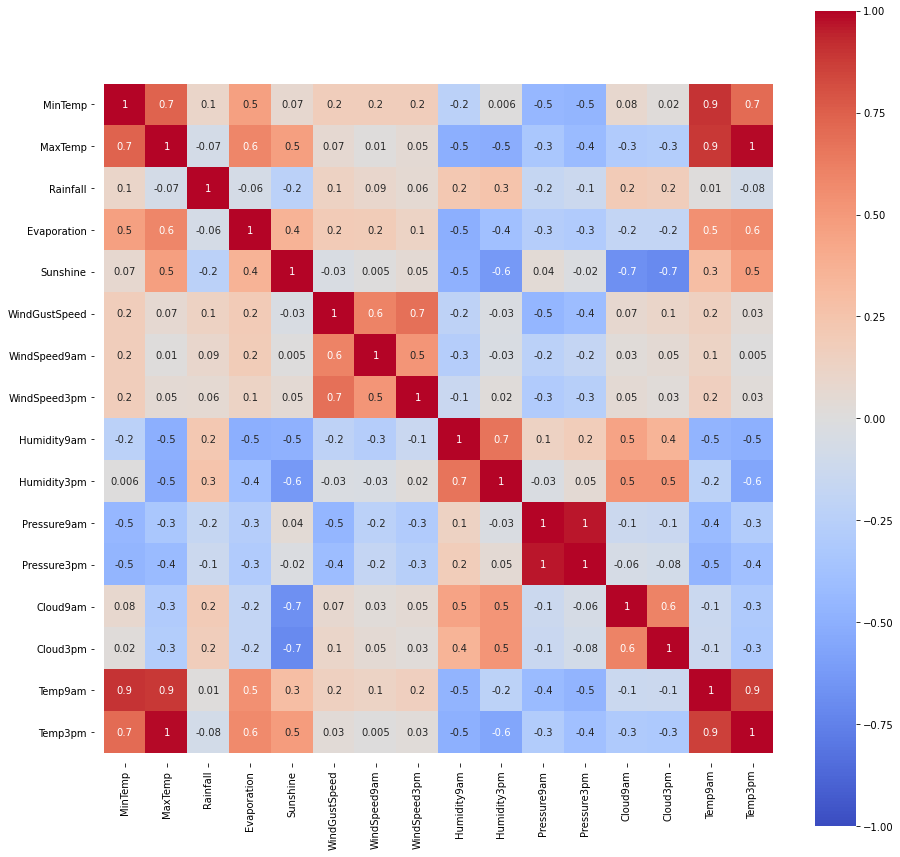

In [8]:
fig, ax = plt.subplots(figsize=(15,15))
sns.despine(offset=10, trim=False)

sns.heatmap(data.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap = 'coolwarm', square=True, ax = ax)

**Здесь кажется очевидной зависимость полей максимальной и минимальной температур, облачности и "солнечности" Также можно увидеть зависимость, а также влажностью и температурой, и влажностью и "солнечностью". Признаки, зафиксированные два раза в течение дня, возможно, в будущем стоит объединить в один признак.**

**Рассмотрим объем данных на каждую локацию:**

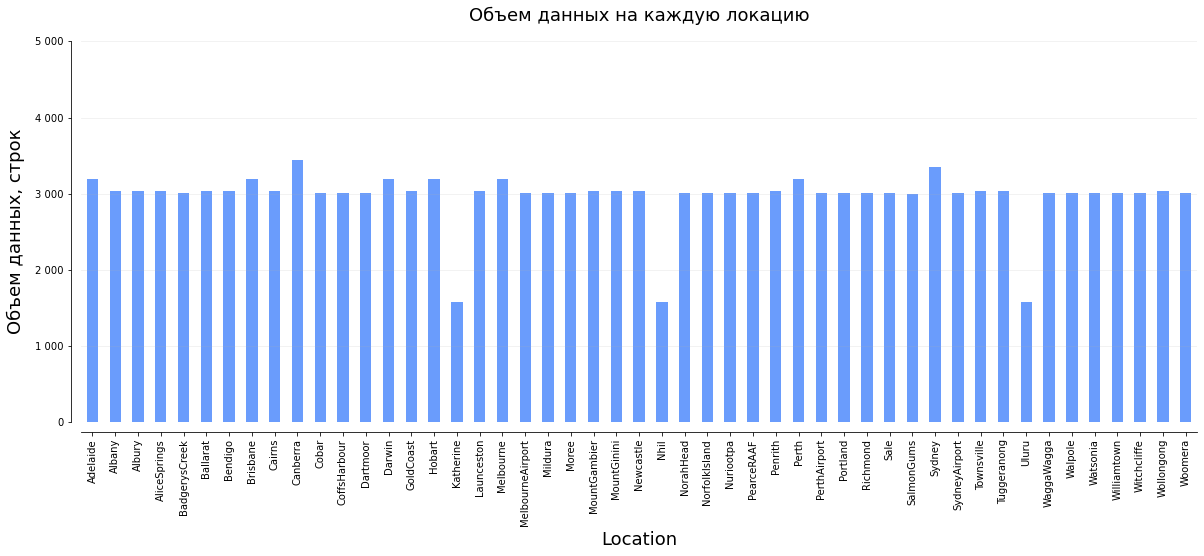

In [12]:
fig, ax = plt.subplots(1,1)


grouped = data.groupby('Location').agg({'Location':'count'}).rename(columns={'Location':'Count_location'})
grouped['Location'] = grouped.index

sns.despine(offset=10, trim=False)
plt.xlabel('Локация',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Объем данных на каждую локацию', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 5000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
grouped.plot(kind = 'bar', x = 'Location', y = 'Count_location', figsize = (20, 7), ax = ax, color = '#6A9CFC', legend = None)
ax.grid(axis='y', alpha=0.2)

**Рассмотрим количества популярных направлений максимально сильных ветров и других различных направлений по часам:**

Text(0.5, 0, 'Направление')

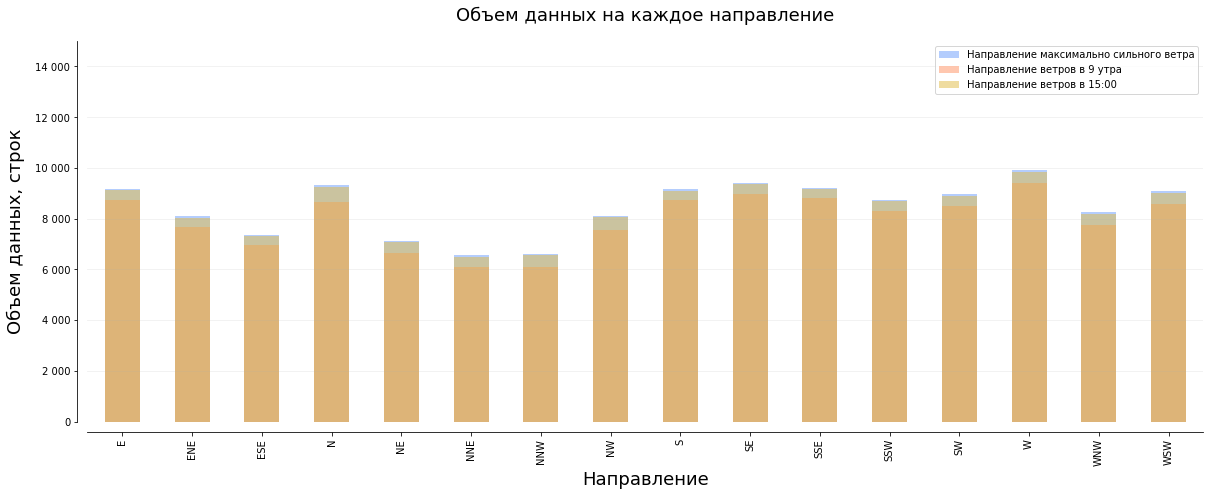

In [127]:
fig, ax = plt.subplots(1,1)

grouped = data.groupby('WindGustDir').agg({'WindGustDir':'count', 'WindDir9am':'count', 'WindDir3pm':'count'}).rename(columns={'WindGustDir':'Count_WindGustDir', 'WindDir9am':'Count_WindDir9am', 'WindDir3pm':'Count_WindDir3pm'})
grouped['WindGustDir'] = grouped.index

sns.despine(offset=10, trim=False)

plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Объем данных на каждое направление', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 15000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
grouped.plot(kind = 'bar', x = 'WindGustDir', y = 'Count_WindGustDir', figsize = (20, 7), ax = ax, color = '#6A9CFC', legend = True, alpha= 0.5, label = 'Направление максимально сильного ветра')
grouped.plot(kind = 'bar', x = 'WindGustDir', y = 'Count_WindDir9am', figsize = (20, 7), ax = ax, color = '#FF9061', legend = True, alpha= 0.5, label = 'Направление ветров в 9 утра')
grouped.plot(kind = 'bar', x = 'WindGustDir', y = 'Count_WindDir3pm', figsize = (20, 7), ax = ax, color = '#E1BA43', legend = True, alpha=0.5, label = 'Направление ветров в 15:00')
ax.grid(axis='y', alpha=0.2)
plt.xlabel('Направление', labelpad=5, fontsize=18) 

**Распределение минимальной температуры:**

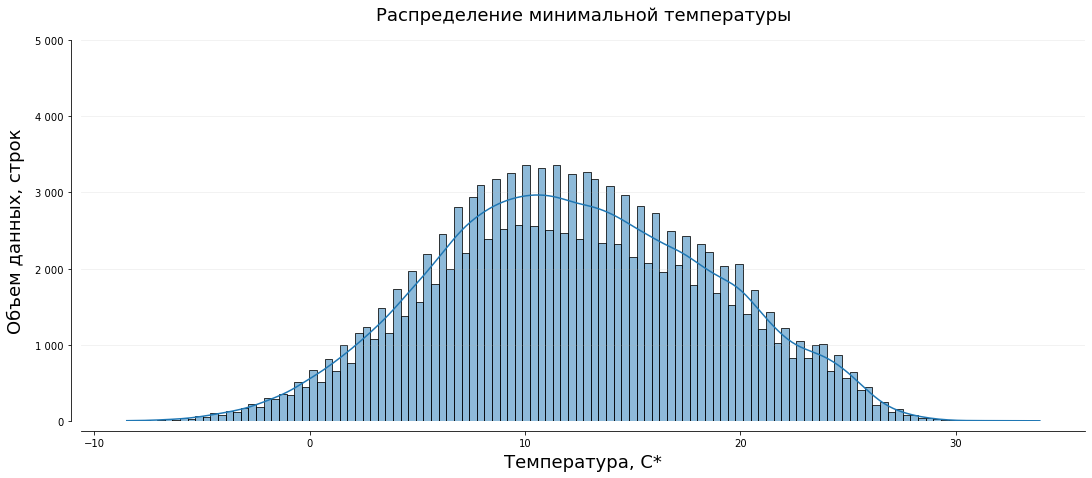

In [76]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Температура, C*',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение минимальной температуры', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 5000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data, x='MinTemp', ax = ax, kde = True, stat = 'count')
ax.grid(axis='y', alpha=0.2)

**Распределение минимальной температуры:**

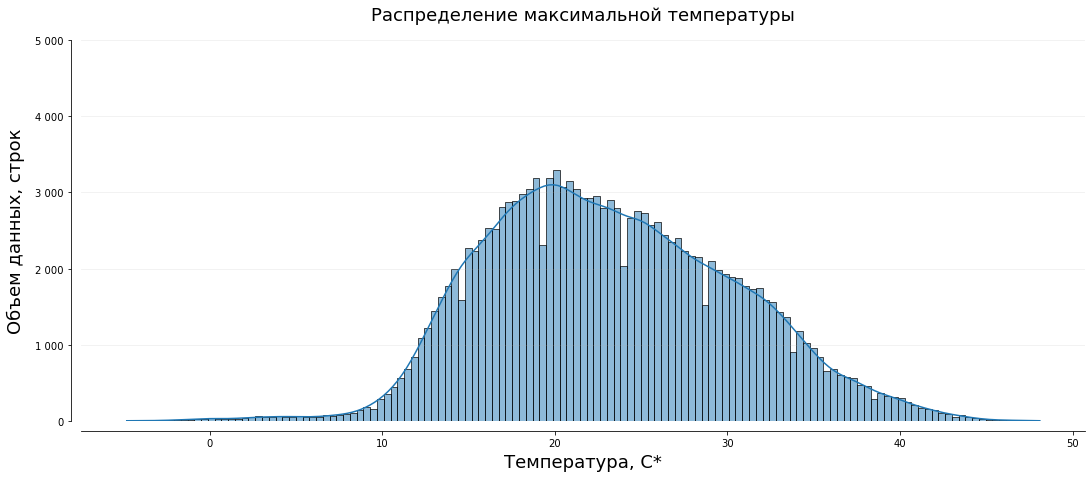

In [77]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Температура, C*',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение максимальной температуры', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 5000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data, x='MaxTemp', ax = ax, kde = True)
ax.grid(axis='y', alpha=0.2)

**Распределение количества осадков:**

In [70]:
data['Rainfall'].value_counts(dropna=False, normalize=True)

0.0      0.626152
0.2      0.060230
0.4      0.026000
NaN      0.022419
0.6      0.017819
           ...   
147.8    0.000007
11.1     0.000007
153.2    0.000007
19.7     0.000007
136.4    0.000007
Name: Rainfall, Length: 682, dtype: float64

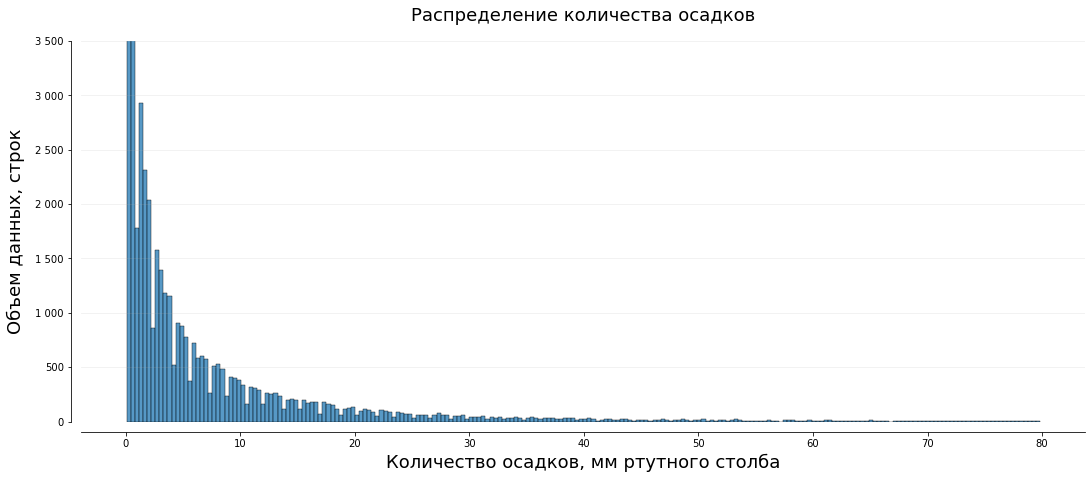

In [129]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Количество осадков, мм ртутного столба',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение количества осадков', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 3500)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data[(data['Rainfall']!=0)&(data['Rainfall']<80)], x = 'Rainfall', ax = ax)
ax.grid(axis = 'y', alpha = 0.2)

**Распределение количества осадков во время  отсутствия дождя (RainToday = 0)**

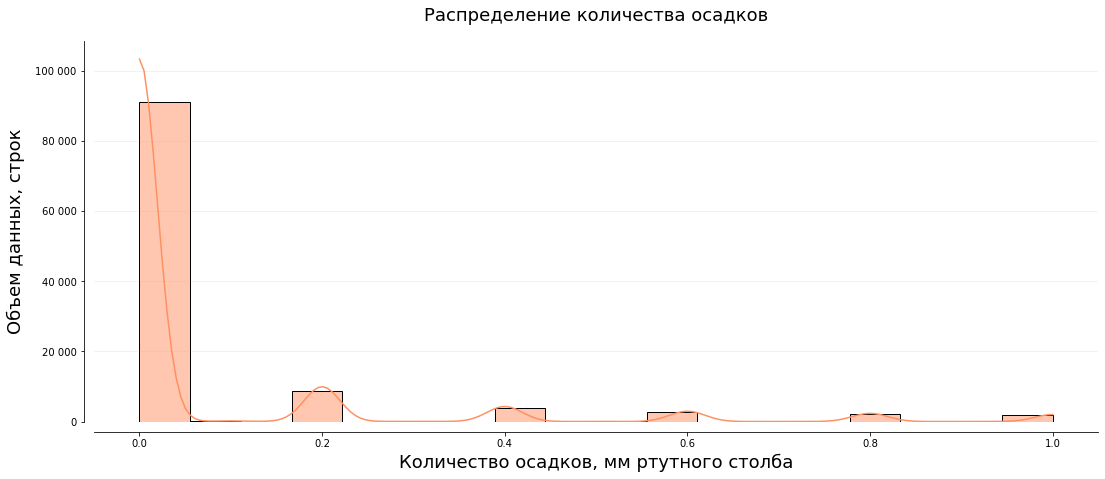

In [249]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Количество осадков, мм ртутного столба',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение количества осадков', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
#ax.set_ylim(0, 3500)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
#sns.histplot(data=data[data['RainToday'] == 1], x = 'Rainfall', ax = ax, color = '#6A9CFC', alpha = 0.5)
sns.histplot(data=data[data['RainToday'] == 0], x = 'Rainfall', ax = ax, color = '#FF9061', kde = True)
ax.grid(axis = 'y', alpha = 0.2)

**Распределение величины испарения:**

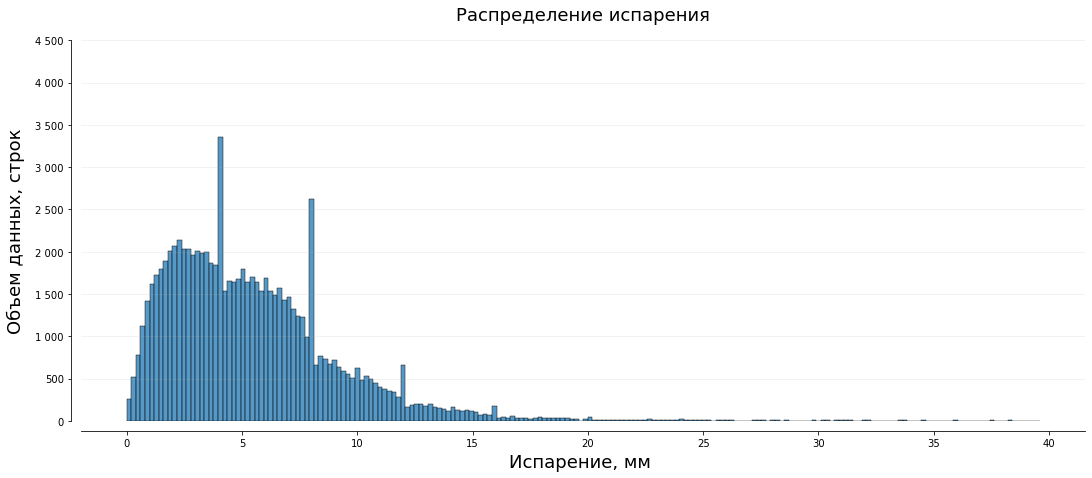

In [100]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Испарение, мм ',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение испарения', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 4500)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data[data['Evaporation']<40], x = 'Evaporation', ax = ax, bins=200)
ax.grid(axis = 'y', alpha = 0.2)

Text(0.5, 0, 'Величина испарения')

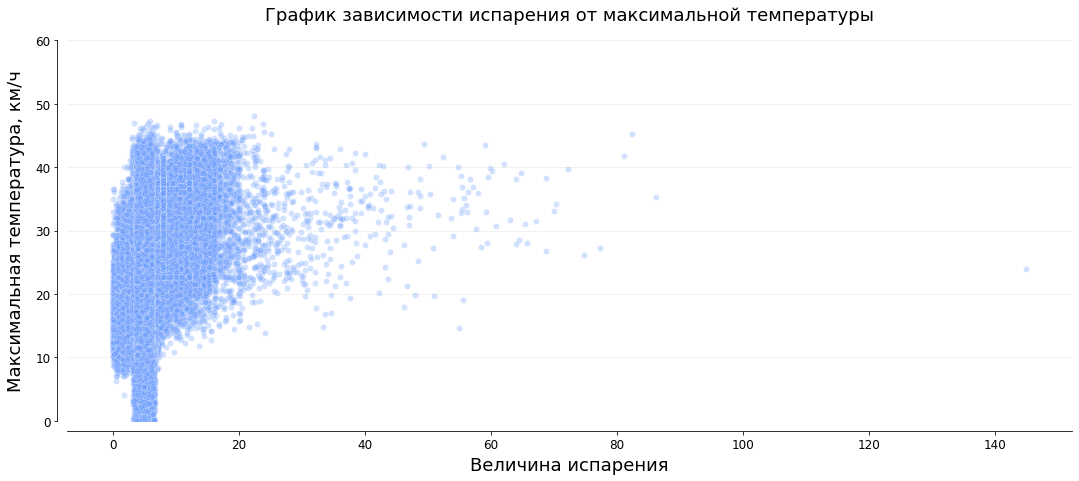

In [394]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset = 10, trim = False)

plt.ylabel('Максимальная температура, км/ч', labelpad=10, fontsize = 18) 
plt.title('График зависимости испарения от максимальной температуры', pad = 20, fontsize = 18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 60)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.scatterplot(data = data, x = 'Evaporation', y = 'MaxTemp', ax = ax, color = '#6A9CFC', legend = True, alpha= 0.3)


ax.grid(axis='y', alpha=0.2)
plt.xlabel('Величина испарения', labelpad=5, fontsize=18)

**Распределение количества солнечных часов:**

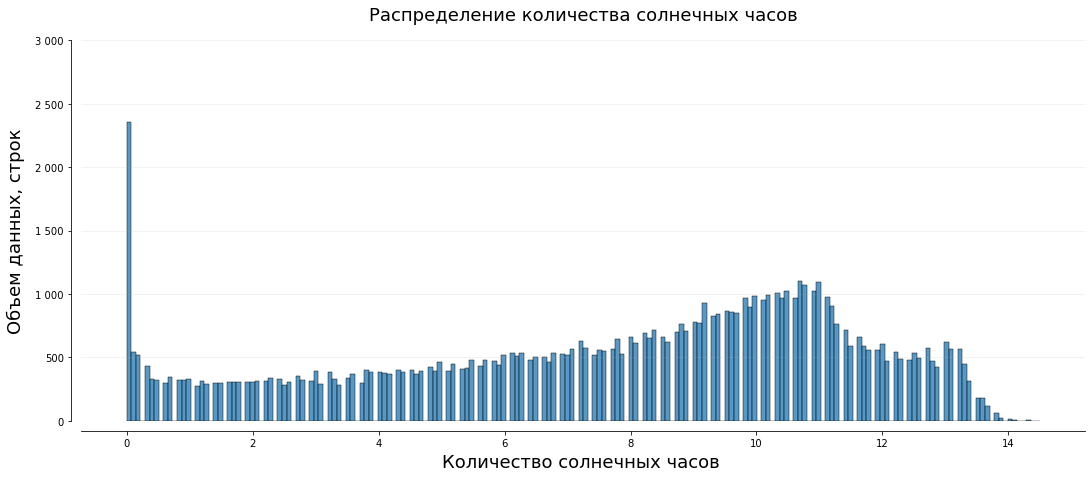

In [86]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Количество солнечных часов ',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение количества солнечных часов', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 3000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data, x = 'Sunshine', ax = ax, bins=200)
ax.grid(axis = 'y', alpha = 0.2)

**Распределение скорости  ветров:**

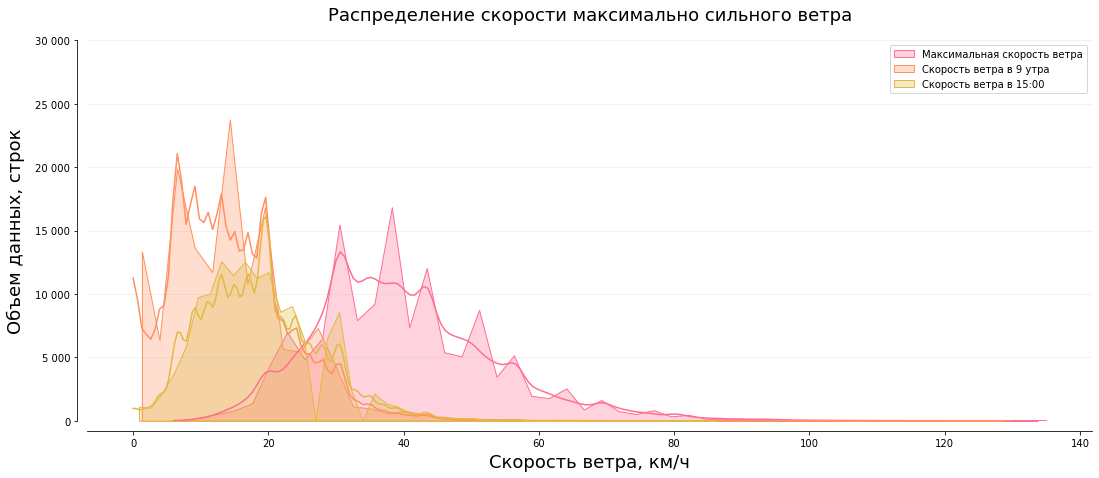

In [163]:
fig, ax = plt.subplots(1,1, figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Скорость ветра, км/ч', labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк', labelpad=10, fontsize=18) 
plt.title('Распределение скорости максимально сильного ветра', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
sns.histplot(data=data, x = 'WindGustSpeed', ax = ax, bins=50, color = '#FF6E93', alpha = 0.3, kde = True, element = "poly", legend = True, label = 'Максимальная скорость ветра')
sns.histplot(data=data, x = 'WindSpeed9am', ax = ax, bins=50, color = '#FF9061', alpha = 0.3, kde = True, element = "poly", legend = True, label = 'Скорость ветра в 9 утра')
sns.histplot(data=data, x = 'WindSpeed3pm', ax = ax, bins=50, color = '#E1BA43', alpha = 0.3, kde = True, element = "poly", legend = True, label = 'Скорость ветра в 15:00')
ax.set_ylim(0, 30000)
ax.legend()
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)

ax.grid(axis = 'y', alpha = 0.2)

**Распределение влажности:**

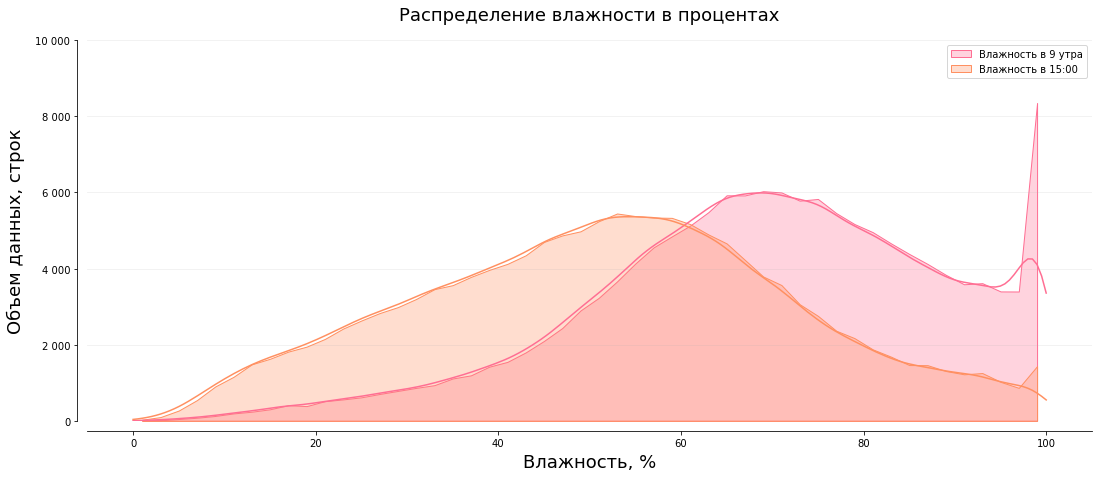

In [164]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Влажность, %',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение влажности в процентах', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 10000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data, x = 'Humidity9am', ax = ax, bins=50, color = '#FF6E93', alpha = 0.3, kde = True, element="poly", legend = True, label = 'Влажность в 9 утра')
sns.histplot(data=data, x = 'Humidity3pm', ax = ax, bins=50, color = '#FF9061', alpha = 0.3, kde = True, element="poly", legend = True, label = 'Влажность в 15:00')
ax.legend()

ax.grid(axis = 'y', alpha = 0.2)

**Распределение давления:**

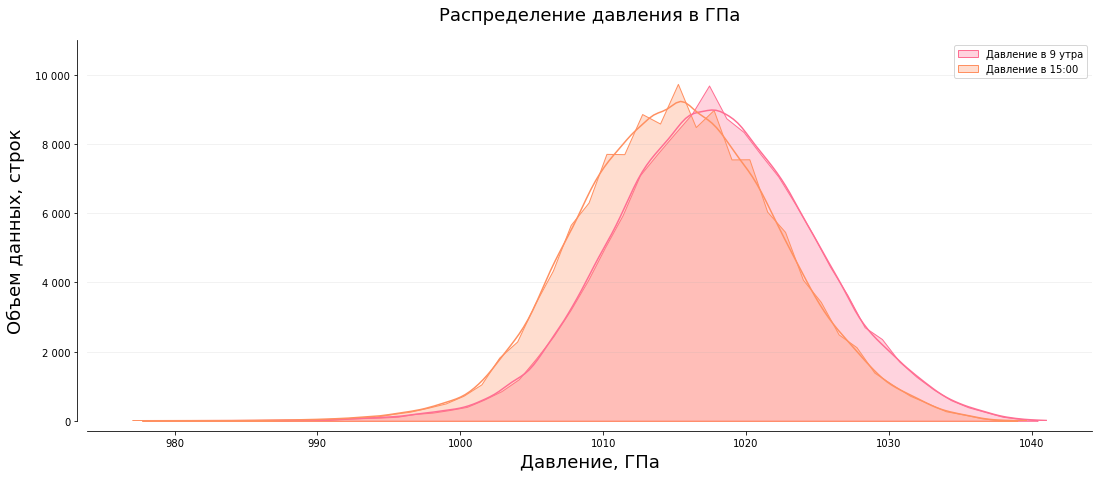

In [166]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

sns.despine(offset=10, trim=False)
plt.xlabel('Давление, ГПа',labelpad=5, fontsize=18) 
plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Распределение давления в ГПа', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 11000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
sns.histplot(data=data, x = 'Pressure9am', ax = ax, bins=50, color = '#FF6E93', alpha = 0.3, kde = True, element="poly", legend = True, label = 'Давление в 9 утра')
sns.histplot(data=data, x = 'Pressure3pm', ax = ax, bins=50, color = '#FF9061', alpha = 0.3, kde = True, element="poly", legend = True, label = 'Давление в 15:00')
ax.legend()

ax.grid(axis = 'y', alpha = 0.2)

**Распределение облачности в октах:**

Text(0.5, 0, 'Величина облачности')

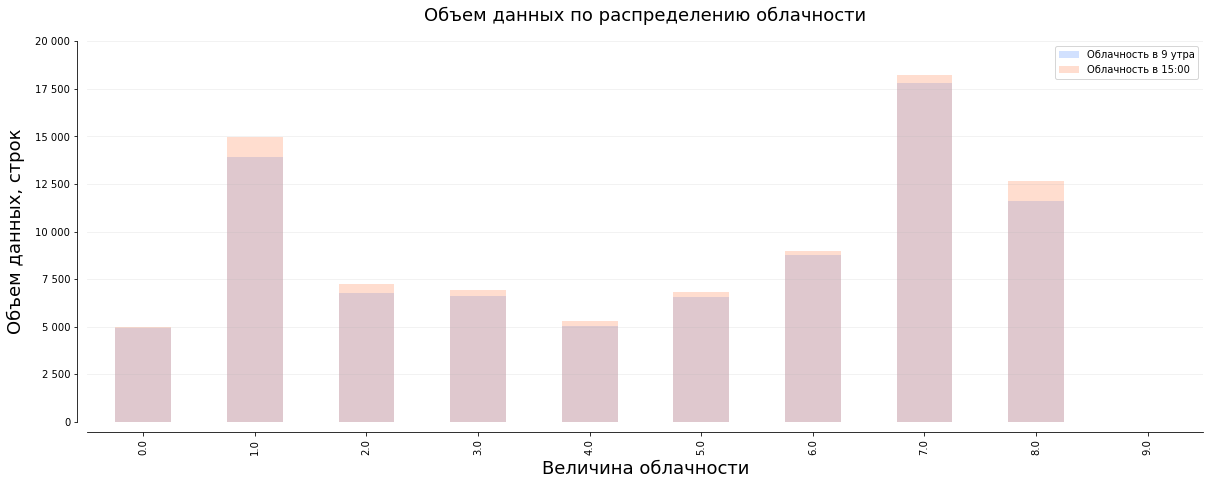

In [179]:
fig, ax = plt.subplots(1,1)

grouped = data.groupby('Cloud3pm').agg({'Cloud3pm':'count', 'Cloud9am':'count'}).rename(columns={'Cloud9am':'Count_Cloud9am', 'Cloud3pm':'Count_Cloud3pm'})
grouped['Cloud3pm'] = grouped.index

sns.despine(offset = 10, trim = False)

plt.ylabel('Объем данных, строк', labelpad=10, fontsize = 18) 
plt.title('Объем данных по распределению облачности', pad = 20, fontsize = 18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 20000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
grouped.plot(kind = 'bar', x = 'Cloud3pm', y = 'Count_Cloud9am', figsize = (20, 7), ax = ax, color = '#6A9CFC', legend = True, alpha= 0.3, label = 'Облачность в 9 утра')
grouped.plot(kind = 'bar', x = 'Cloud3pm', y = 'Count_Cloud3pm', figsize = (20, 7), ax = ax, color = '#FF9061', legend = True, alpha= 0.3, label = 'Облачность в 15:00')

ax.grid(axis='y', alpha=0.2)
plt.xlabel('Величина облачности', labelpad=5, fontsize=18)

**Распределение классов:**

In [3]:
data['RainToday'] = data['RainToday'].map({'Yes':1, 'No':0})
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1, 'No':0})

Text(0.5, 0, 'Метки класса дождливого дня')

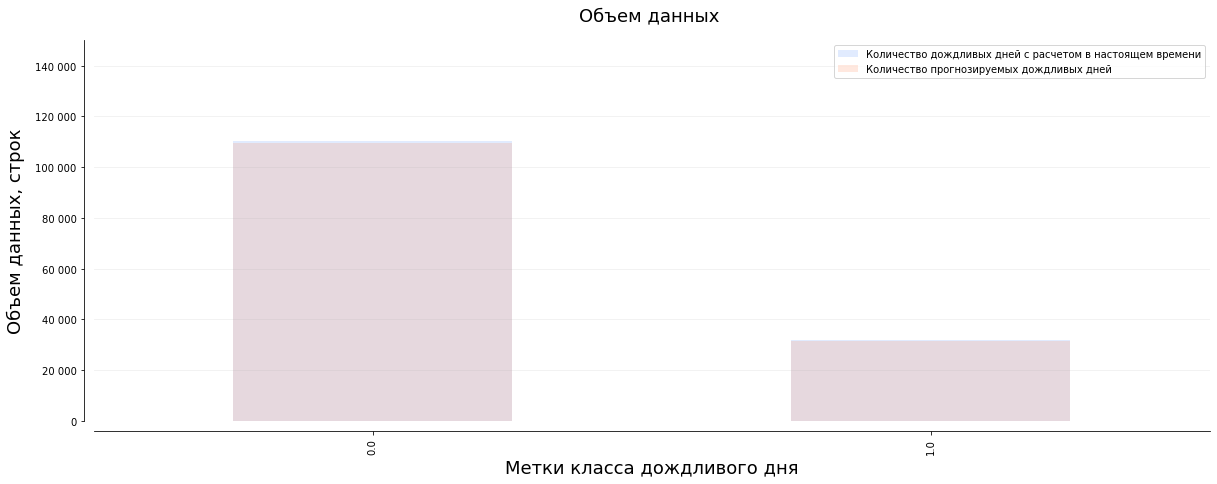

In [191]:
fig, ax = plt.subplots(1,1)

grouped = data.groupby('RainToday').agg({'RainToday':'count', 'RainTomorrow':'count'}).rename(columns={'RainToday':'Count_RainToday', 'RainTomorrow':'Count_RainTomorrow'})
grouped['RainToday'] = grouped.index

sns.despine(offset=10, trim=False)

plt.ylabel('Объем данных, строк',labelpad=10, fontsize=18) 
plt.title('Объем данных ', pad = 20, fontsize=18)

set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0, 150000)
ax.get_yaxis().set_major_formatter(set_space_thousands_sep)
grouped.plot(kind = 'bar', x = 'RainToday', y = 'Count_RainToday', figsize = (20, 7), ax = ax, color = '#6A9CFC', legend = True, alpha= 0.2, label = 'Количество дождливых дней с расчетом в настоящем времени')
grouped.plot(kind = 'bar', x = 'RainToday', y = 'Count_RainTomorrow', figsize = (20, 7), ax = ax, color = '#FF9061', legend = True, alpha= 0.2, label = 'Количество прогнозируемых дождливых дней')

ax.grid(axis='y', alpha=0.2)
plt.xlabel('Метки класса дождливого дня', labelpad=5, fontsize = 18) 

**Можно увидеть, что классы не сбалансированы!**

In [193]:
data['RainToday'].value_counts(dropna=False)

0.0    110319
1.0     31880
NaN      3261
Name: RainToday, dtype: int64

In [194]:
data['RainTomorrow'].value_counts(dropna=False)

0.0    110316
1.0     31877
NaN      3267
Name: RainTomorrow, dtype: int64

## Работа с пропусками:

Работа с полями **максимальных и минимальных температур**: заменим пропуски медианными значениями, так как распределение данных - нормальное. Будем и использовать эти признаки, вместо признаков, соответствующих температурам в 9 утра и в 15:00, так как они сильно скоррелированы и имеют больше пропусков!

In [5]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(data[['MinTemp', 'MaxTemp']])
data[['MinTemp', 'MaxTemp']] = imputer.transform(data[['MinTemp', 'MaxTemp']])

In [6]:
data[['MinTemp', 'MaxTemp']].isna().sum()

MinTemp    0
MaxTemp    0
dtype: int64

Работа с полем осадков **Rainfall**: так как распределение экспоненциальное, то можем, предположить, что если дождя в соответствующий день нет - то заменяем 0, иначе рандомизированным значением от 1 до 40.

In [7]:
for i in tqdm(range(len(data[['Rainfall']]))):
    if np.isnan(data.loc[i,'Rainfall']) and  data.loc[i,'RainToday'] == 0:
        data.loc[i,'Rainfall'] = random.uniform(0, 1)
    elif np.isnan(data.loc[i,'Rainfall']) and  data.loc[i,'RainToday'] != 0:
        data.loc[i,'Rainfall'] = random.uniform(1, 40)

100%|███████████████████████████████████████████████████████████████████████| 145460/145460 [00:04<00:00, 29357.49it/s]


In [8]:
data['Rainfall'].isna().sum()

0

Работа с полем **Evaporation**. Заменим пропуски рандоминизрованными значениями в пределах +- межквартильного размаха.

In [9]:
for i in tqdm(range(len(data[['Evaporation']]))):
    if np.isnan(data.loc[i,'Evaporation']):
        data.loc[i,'Evaporation'] = random.uniform(data['Evaporation'].quantile(0.25), data['Evaporation'].quantile(0.75))

100%|█████████████████████████████████████████████████████████████████████████| 145460/145460 [05:58<00:00, 405.51it/s]


Работа с полем **Sunshine**: если дождя в соответствующий день нет, то можем заменить пропущенное значение на 0, в ином случае

In [10]:
data[data['RainToday'] == 1]['Sunshine'].value_counts()[0:5]

0.0    1303
0.2     252
0.1     233
7.2     185
6.8     182
5.5     180
5.0     178
Name: Sunshine, dtype: int64

In [11]:
data[data['RainToday'] == 0]['Sunshine'].value_counts()[0:10]

0.0     1010
11.0     998
10.8     990
10.7     989
10.9     947
10.5     937
10.3     919
11.1     904
10.0     889
Name: Sunshine, dtype: int64

In [12]:
for i in tqdm(range(len(data[['Sunshine']]))):
    if np.isnan(data.loc[i,'Sunshine']) and  data.loc[i,'RainToday'] == 0:
        data.loc[i,'Sunshine'] = random.uniform(10, 11)
    elif np.isnan(data.loc[i,'Sunshine']) and  data.loc[i,'RainToday'] != 0:
        data.loc[i,'Sunshine'] = 0

100%|████████████████████████████████████████████████████████████████████████| 145460/145460 [01:03<00:00, 2300.23it/s]


Работа с полем **WindGustDir, WindDir9am, WindDir15pm**: в случае пропуска замена будет проводиться рандомизированным методом с помощью весов.

In [13]:
directions = list(data['WindGustDir'].unique())
prob = list(data['WindGustDir'].value_counts(normalize = True))

data.loc[data['WindGustDir'].isna(),'WindGustDir'] = np.random.choice(directions, len(data[data['WindGustDir'].isna()]), prob)

In [14]:
directions = list(data['WindDir9am'].unique())
prob = list(data['WindDir9am'].value_counts(normalize = True))

data.loc[data['WindDir9am'].isna(),'WindDir9am'] = np.random.choice(directions, len(data[data['WindDir9am'].isna()]), prob)

In [15]:
directions = list(data['WindDir3pm'].unique())
prob = list(data['WindDir3pm'].value_counts(normalize = True))

data.loc[data['WindDir3pm'].isna(),'WindDir3pm'] = np.random.choice(directions, len(data[data['WindDir3pm'].isna()]), prob)

**Работа с полями WindGustSpeed, WindSpeed9am, WindSpeed3pm: замена на медианное значение**

In [16]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(data[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']])
data[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']] = imputer.transform(data[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']])

**Работа с полями Humidity9am, Humidity3pm: замена на медианное значение:**

In [17]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(data[['Humidity9am', 'Humidity3pm']])
data[['Humidity9am', 'Humidity3pm']] = imputer.transform(data[['Humidity9am', 'Humidity3pm']])

**Работа с полями Pressure9am, Pressure3pm: замена на медианное значение:**

In [18]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(data[['Pressure9am', 'Pressure3pm']])
data[['Pressure9am', 'Pressure3pm']] = imputer.transform(data[['Pressure9am', 'Pressure3pm']])

**Работа с полем Cloud9am, Cloud3pm: замена на рандоминизированное значение с определенным весом.**

In [34]:
directions = list(data['Cloud9am'].unique())
prob = list(data['Cloud9am'].value_counts(normalize = True))

data.loc[data['Cloud9am'].isna(),'Cloud9am'] = np.random.choice(directions, len(data[data['Cloud9am'].isna()]), prob)

In [35]:
directions = list(data['Cloud3pm'].unique())
prob = list(data['Cloud3pm'].value_counts(normalize = True))

data.loc[data['Cloud3pm'].isna(),'Cloud3pm'] = np.random.choice(directions, len(data[data['Cloud3pm'].isna()]), prob)

**Итого:**

In [36]:
data.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am          1767
Temp3pm          3609
RainToday        3261
RainTomorrow     3267
dtype: int64

## Создание baseline модели:

In [37]:
# Отфильтруем наши данные по определенным признакам и избавимся от пропущенных значений в целевой переменной:

filter_data = data[(~data['RainToday'].isna())&(~data['RainTomorrow'].isna())]
filter_data = filter_data[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
             'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
             'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainTomorrow']]

In [38]:
X = filter_data.iloc[:,:12]
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [39]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [40]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [41]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8208442834481615
Precision: 0.6562266964951529
Recall: 0.380828735259115
ROC_AUC: 0.8184432616538799


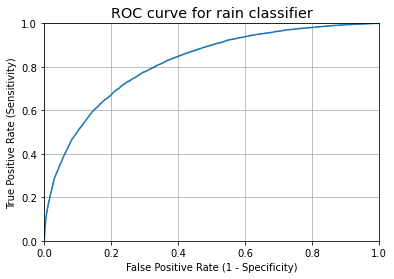

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for rain classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Создание и преобразование признаков:

**Добавим колонку "Время года":**

In [33]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
    
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data.Date.map(season_of_date)

In [43]:
data['month'] = pd.to_datetime(data['Date']).apply(lambda x: x.month)

**Работа с категориальными признаками:**

Добавим дополнительные столбцы-метки локаций, месяцев (информация, которую можно вытащить из даты, взамен месяцам года). А также вынесем информацию из полей с направлениями ветра в отдельные столбцы. Также вынесем информацию из поля RainToday.

In [44]:
data = pd.get_dummies(data = data, columns = ['Location'])
data = pd.get_dummies(data = data, columns = ['month'])

In [45]:
data = pd.get_dummies(data = data, columns = ['WindGustDir'])
data = pd.get_dummies(data = data, columns = ['WindDir9am'])
data = pd.get_dummies(data = data, columns = ['WindDir3pm'])

In [46]:
data = pd.get_dummies(data = data, columns = ['RainToday'])

## Результат модели на измененных данных с новыми столбцами без масштабирования:

In [47]:
filter_data = data[(~data['RainTomorrow'].isna())]
filter_data = filter_data.drop(columns=['Date','Temp9am', 'Temp3pm'])

In [48]:
X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [51]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8432650382108866
Precision: 0.7215453671048413
Recall: 0.4762962962962963
ROC_AUC: 0.8582173257161212


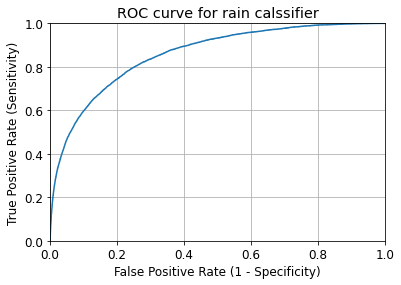

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for rain calssifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Результат модели на сбалансированной выборке:

**Уравняем выборки для каждой метки класса: сделаем undersampling**

In [53]:
filter_data = data[(~data['RainTomorrow'].isna())]
filter_data['RainTomorrow'].value_counts()

0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64

In [54]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

In [58]:
#filter_data = filter_data.drop(columns=['Date','Temp9am', 'Temp3pm'])

In [59]:
X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [62]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.7717362890155278
Precision: 0.7855195725656963
Recall: 0.7501822347183172
ROC_AUC: 0.8577339793410317


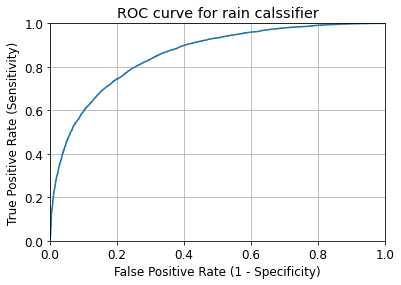

In [63]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for rain calssifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Результат модели на масштабируемой выборке:

In [407]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_0.0,RainToday_1.0
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,143693.000000,141851.00000,142193.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.192053,23.215962,2.769448,5.227890,7.765155,39.962189,14.030751,18.669758,68.901251,51.553396,1017.644768,1015.250115,4.477121,4.508236,16.990631,21.68339,0.224181,0.021951,0.020899,0.

**Можно увидеть, что в некоторых признаках разница между минимальным и максимальным значением велика, поэтому стоит попробовать MinMax Scale:**

In [409]:
mms = MinMaxScaler()
mms.fit(X_train)

MinMaxScaler()

In [410]:
mms.transform(X_train)

array([[0.33002481, 0.38610039, 0.02641509, ..., 0.        , 0.        ,
        1.        ],
       [0.63523573, 0.47683398, 0.01239892, ..., 0.        , 0.        ,
        1.        ],
       [0.60049628, 0.68532819, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.64516129, 0.83204633, 0.00161725, ..., 0.        , 1.        ,
        0.        ],
       [0.4292804 , 0.42664093, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.53846154, 0.6003861 , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [411]:
X_train_norm = pd.DataFrame(mms.transform(X_train), columns=X_train.columns)
X_train_norm

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_0.0,RainToday_1.0
0,0.330025,0.386100,0.026415,0.064492,0.000000,0.218750,0.103448,0.195402,0.949495,0.64,0.544702,0.554828,0.777778,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.635236,0.476834,0.012399,0.098930,0.482759,0.335938,0.379310,0.425287,0.545455,0.59,0.701987,0.754501,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.600496,0.685328,0.000000,0.084718,0.754042,0.265625,0.298851,0.126437,0.656566,0.37,0.682119,0.687398,0.666667,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.578164,0.465251,0.009164,0.093739,0.000000,0.320312,0.149425,0.379310,0.787879,0.56,0.437086,0.497545,0.777778,0.555556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [412]:
X_test_norm = pd.DataFrame(mms.transform(X_test), columns=X_train.columns)
X_test_norm.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_0.0,RainToday_1.0
count,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.00000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.00000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000,19127.000000
mean,0.522813,0.527188,0.010660,0.067336,0.468289,0.272077,0.166207,0.219143,0.717435,0.575249,0.597251,0.608167,0.539935,0.546313,0.021436,0.023684,0.020390,0.016207,0.019501,0.022743,0.020076,0.023788,0.024102,0.024259,0.017096,0.023684,0.022952,0.024468,0.023056,0.024573,0.010875,0.020233,0.019710,0.020442,0.017828,0.016939,0.023004,0.021906,0.021802,0.009097,0.021802,0.022377,0.020338,

In [413]:
model = LogisticRegression()
model.fit(X_train_norm, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [414]:
y_pred = model.predict(X_test_norm)
y_pred_prob = model.predict_proba(X_test_norm)[:, 1]

In [416]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.7871072306164061
Precision: 0.7980263863563231
Recall: 0.7726659050784089
ROC_AUC: 0.870306490397889


## Использование RandomForest:

In [421]:
filter_data = data[(~data['RainTomorrow'].isna())]
filter_data = filter_data.drop(columns=['Date','Temp9am', 'Temp3pm'])

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [423]:
%%time

RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)

Wall time: 20.7 s


RandomForestClassifier()

In [424]:
y_pred = RFmodel.predict(X_test)
y_pred_prob = RFmodel.predict_proba(X_test)[:, 1]

In [425]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8538609405035398
Precision: 0.775634685130234
Recall: 0.4912299018584256
ROC_AUC: 0.8837333982577464


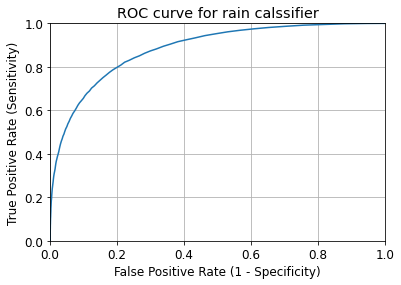

In [426]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for rain calssifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Тюнинг RandomForest с помощью GridSearch:

In [429]:
%%time

RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42)

param_grid = { 
    'n_estimators': [200, 500, 700, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'criterion': ['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator = RFmodel, param_grid = param_grid, cv = 5)
CV_rfc.fit(X_train, y_train)

Wall time: 1h 53min 14s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 700, 1000]})

In [430]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500}

In [431]:
%%time

RFmodelSelected = RandomForestClassifier(criterion = 'gini', max_depth = 10, max_features = 'auto', n_estimators = 500)

RFmodelSelected.fit(X_train, y_train)

Wall time: 42.7 s


RandomForestClassifier(max_depth=10, n_estimators=500)

In [433]:
y_pred = RFmodelSelected.predict(X_test)
y_pred_prob = RFmodelSelected.predict_proba(X_test)[:, 1]

In [434]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8395142763373811
Precision: 0.7901444350042481
Recall: 0.38839006055543956
ROC_AUC: 0.8607968861530972


## RandomForest на сбалансированной выборке:

In [435]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [436]:
RFmodelSelected = RandomForestClassifier(criterion = 'gini', max_depth = 10, max_features = 'auto', n_estimators = 500)

RFmodelSelected.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [439]:
y_pred = RFmodelSelected.predict(X_test)
y_pred_prob = RFmodelSelected.predict_proba(X_test)[:, 1]

In [440]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.7788989386730799
Precision: 0.7853689977441186
Recall: 0.7661915740934815
ROC_AUC: 0.8630513293943467


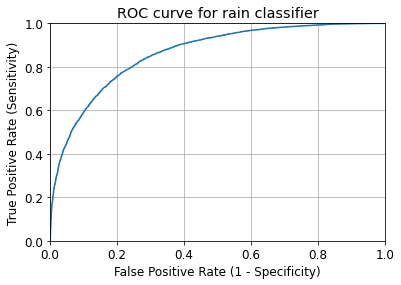

In [442]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for rain classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Ошибка на обучающей и тестовой выборке:

In [ ]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [449]:
max_depth_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
train_errors = []
test_errors = []
print('Precision:', )
for i in tqdm(max_depth_list):
    RFmodelSelected = RandomForestClassifier(criterion = 'gini', max_depth = i, max_features = 'auto', n_estimators = 500)
    RFmodelSelected.fit(X_train, y_train)
    train_errors.append(metrics.precision_score(y_train, RFmodelSelected.predict(X_train)))
    test_errors.append(metrics.precision_score(y_test, RFmodelSelected.predict(X_test)))

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

Precision:


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [04:41<00:00, 21.68s/it]


In [450]:
errors_table = pd.DataFrame({'max_depth':max_depth_list, 'train_errors':train_errors, 'test_errors':test_errors})

(0.6, 1.0)

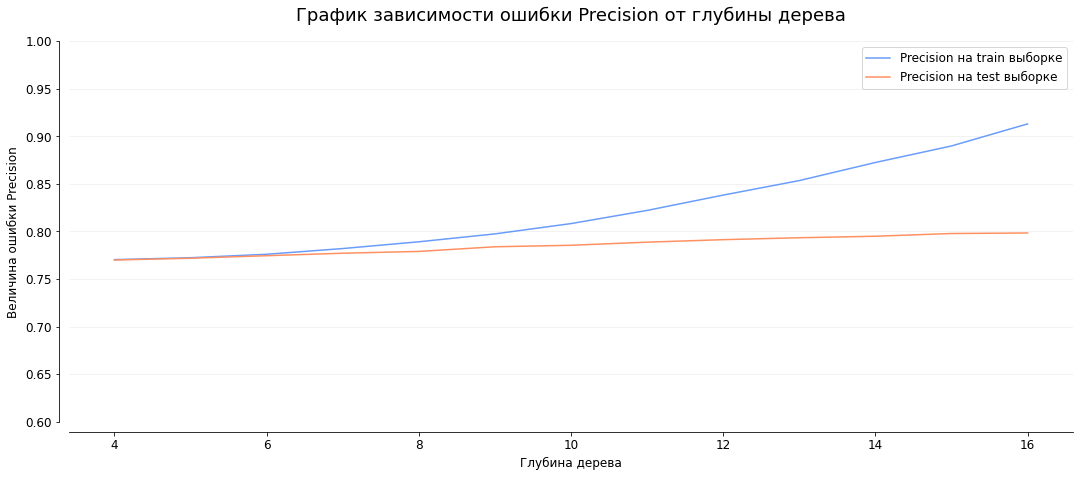

In [467]:
fig, ax = plt.subplots(1,1)
#ax.set_xticks(range(13))

errors_table.plot(kind = 'line', x = 'max_depth', y = 'train_errors', 
                           figsize = (18, 7), ax = ax, color = '#6A9CFC', legend = True, label = 'Precision на train выборке')

errors_table.plot(kind = 'line', x = 'max_depth', y = 'test_errors', 
                           figsize = (18, 7), ax = ax, color = '#FF9061', legend = True, label = 'Precision на test выборке')

sns.despine(offset=10, trim=False)
plt.xlabel('Глубина дерева',labelpad=5) 
plt.ylabel('Величина ошибки Precision',labelpad=5) 
plt.title('График зависимости ошибки Precision от глубины дерева', pad = 20, fontsize=18)
ax.grid(axis='y', alpha=0.2)
#set_space_thousands_sep = mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', ' '))
ax.set_ylim(0.6, 1)
#ax.get_yaxis().set_major_formatter(set_space_thousands_sep)

## GradientBoosting:

In [462]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [463]:
GBModel = GradientBoostingClassifier()
GBModel.fit(X_train, y_train)

GradientBoostingClassifier()

In [464]:
y_pred = GBModel.predict(X_test)
y_pred_prob = GBModel.predict_proba(X_test)[:, 1]

In [465]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.7853296387305903
Precision: 0.7887129344244872
Recall: 0.7779641471852395
ROC_AUC: 0.8704662332353363


## XGBoost Classifier:

In [64]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [65]:
XGBModel = XGBClassifier()
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [66]:
y_pred = XGBModel.predict(X_test)
y_pred_prob = XGBModel.predict_proba(X_test)[:, 1]

In [67]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8028441470173053
Precision: 0.8018487037824055
Recall: 0.7983708875489263
ROC_AUC: 0.8861847131541681


**Попробуем провести подбор гиперпараметров:**

In [68]:
part1 = filter_data[filter_data['RainTomorrow'] == 1]
part2 = filter_data[filter_data['RainTomorrow'] == 0].sample(31877)
filter_data = pd.concat([part1, part2]).sample(63754)

X = filter_data.drop(columns=['RainTomorrow'])
y = filter_data['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [69]:
%%time

XGBModel = XGBClassifier(n_jobs = -1, random_state = 42)

param_grid = {'gamma': [0,0.2,1.6,12.8],
              'learning_rate': [0.01,0.15,0.25,0.7],
              'max_depth': [7,10,13,14],
              'n_estimators': [65,100,130,150]}
#               'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6, 51.2, 102.4, 200],
#               'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6, 51.2, 102.4, 200]}

CV_rfc = GridSearchCV(estimator = XGBModel, param_grid = param_grid, cv = 5)
CV_rfc.fit(X_train, y_train)

Wall time: 3h 35min 36s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [70]:
CV_rfc.best_params_

{'gamma': 0, 'learning_rate': 0.15, 'max_depth': 7, 'n_estimators': 150}

In [71]:
XGBModel = XGBClassifier(gamma =  0, learning_rate = 0.15, max_depth = 7, n_estimators = 150)
XGBModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
y_pred = XGBModel.predict(X_test)
y_pred_prob = XGBModel.predict_proba(X_test)[:, 1]

In [73]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.8058242275317614
Precision: 0.809437386569873
Recall: 0.7971822100725475
ROC_AUC: 0.8897439404168324
